# Model Building

### Installing requirements

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

### Loading DataSet

In [320]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

train.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,target,6sqr
0,236,488,16,221,382,97,-4.472136,0.107472,0,132,...,0.870542,1.962937,7.466666,11.547794,8.822916,9.046424,7.895535,11.010677,20.107472,20.0
1,386,206,357,232,1,198,7.810250,0.763713,1,143,...,7.168680,2.885415,12.413973,10.260494,10.091351,9.270888,3.173994,13.921871,61.763713,61.0
2,429,49,481,111,111,146,8.602325,0.651162,1,430,...,0.394970,8.160625,12.592059,8.937577,2.265191,11.255721,12.794841,12.080951,74.651162,74.0
3,414,350,481,370,208,158,8.306624,0.424645,1,340,...,6.416708,10.549814,11.456437,6.468099,2.519049,0.258284,9.317696,5.383098,69.424645,69.0
4,318,359,20,218,317,301,8.124038,0.767304,1,212,...,1.919999,2.268203,0.149421,4.105907,10.416291,6.816217,8.586960,4.512419,66.767304,66.0


### Data Preprocessing

In [321]:
#=======================================================================================
# Splitting Dataset :
#=======================================================================================

y_train = train.target
X_train = train.drop(columns='target')

X_test = test

In [322]:
#=======================================================================================
# Feature Scaling :
#=======================================================================================

# Using Min Max scaler
scaler = MinMaxScaler()

In [323]:
# Scaling training dataset
columns = X_train.columns
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = columns

# Scaling test dataset
columns = X_test.columns
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = columns

# Remembering mean and std for future unscaling
target_mean = y_train.mean()
target_std = y_train.std()

# Scaling target feature
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_train_scaled = y_train_scaled.reshape(1, -1)[0]

### Feature selection

After Data Analysis step we have discovered, that only feature 6 (squared) has a strong correlation with target feature. Now let's fit simple Linear Regression and check features importance

Feature: 7, Score: 0.01000
Feature: 6sqr, Score: 0.99003


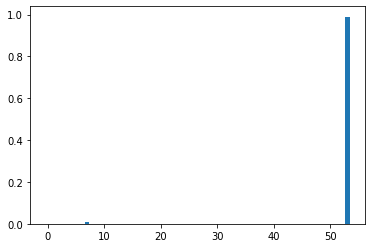

In [324]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

importance = model.coef_
feature_names = model.feature_names_in_

# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.001:
	    print(f'Feature: {feature_names[i]}, Score: {v:.5f}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

As it was expected, feature 6 has a very big importance. But it also turned out, that feature 7 has a very little impact on prediction. We will use these 2 features for Regression

In [325]:
X_train_scaled = X_train_scaled[["6sqr", "7"]]
X_test_scaled = X_test_scaled[["6sqr", "7"]]

### Building a model

Now let's select the best regressor

In [326]:
#=======================================================================================
# Selecting Best Regressor :
#=======================================================================================

regressors = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random_Forest": RandomForestRegressor()
}

results = pd.DataFrame(columns=["Regressor", "Avg_RMSE", "Avg_r2"])
for name, reg in regressors.items():
    model = reg
    cv_results = cross_validate(
        model, X_train_scaled, y_train_scaled, cv=10,
        scoring=('r2', 'neg_root_mean_squared_error')
    )

    results = results.append({
        "Regressor": name,
        "Avg_RMSE": np.abs(cv_results['test_neg_root_mean_squared_error']).mean(),
        "Avg_r2": np.abs(cv_results['test_r2']).mean()
    }, ignore_index=True)

results = results.sort_values("Avg_RMSE", ascending=True)
results.reset_index(drop=True)

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_5162/3726688754.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_5162/3726688754.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_5162/3726688754.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_5162/3726688754.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Regressor,Avg_RMSE,Avg_r2
0,Linear Regression,0.0,1.0
1,Random_Forest,0.000007,1.0
2,Ridge,0.000042,1.0
3,Lasso,0.288977,0.000075


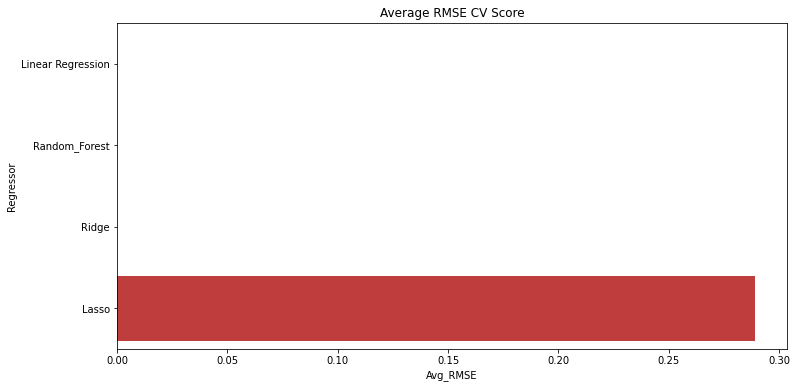

In [327]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x="Avg_RMSE", y="Regressor")
plt.title("Average RMSE CV Score")
plt.show()

Linear Regression showed the best result. I will use this model for predictions

In [328]:
#=======================================================================================
# Training a model :
#=======================================================================================

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

print("Successfully trained a model")

Successfully trained a model


In [329]:
y_pred = model.predict(X_train_scaled)

print(f"Train RMSE: {mean_squared_error(y_train_scaled, y_pred)}")

Train RMSE: 2.8718211865727225e-32


### Making Submission

In [330]:
# Making prediction
y_pred_scaled = model.predict(X_test_scaled)

# Unscaling predicted values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1)).reshape(1, -1)[0]

submission = pd.Series(data=y_pred, name="target")
submission.to_csv('predicted.csv', index=False)

print("SUBMITTED")

SUBMITTED
